In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from statistics import mean

%config IPCompleter.greedy=True

REBUILD_DATA = False
training_data = []
device = torch.device("cuda:0")
IMG_SIZE = 256

In [2]:
class DogsVSCats():
    IMG_SIZE = 256
    CATS = "dog-vs-cats-dataset/Cat"
    DOGS = "dog-vs-cats-dataset/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
else:
    training_data = np.load("training_data.npy", allow_pickle=True)

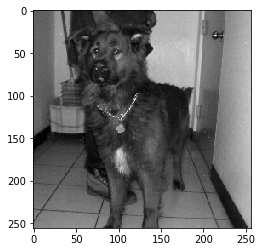

In [3]:
plt.imshow(training_data[1][0], cmap="gray")
plt.show()

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(IMG_SIZE,IMG_SIZE).view(-1,1,IMG_SIZE,IMG_SIZE)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 350)
        self.fc2 = nn.Linear(350, 350)
        self.fc3 = nn.Linear(350, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        layer_1out = F.relu(self.fc1(x))
        layer_2out = F.relu(self.fc2(layer_1out))
        out = F.softmax(self.fc3(layer_2out), dim=1)
        return out
    
    def train(self, train_X, train_y, lr=0.001, EPOCHS=5, BATCH_SIZE=100):
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=0.01)
        lambda1, lambda2 = 0.5, 0.01
        loss_function = nn.BCELoss()
        loss = 0
        
        for epoch in range(EPOCHS):
            for i in range(0, len(train_X), BATCH_SIZE):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, IMG_SIZE, IMG_SIZE).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)

                self.zero_grad()

                outputs = self.forward(batch_X)
                loss = loss_function(outputs, batch_y)
                
                loss.backward()
                optimizer.step()
            
            clear_output(wait=True)
            print(f"Epoch: [{epoch + 1}/{EPOCHS}]  Loss: {loss}")
        return loss
        
        
    def test(self, test_X, test_y, size=100):
        random_start = np.random.randint(len(test_X) - size)
        X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
        with torch.no_grad():
            val_acc, val_loss = self.__test_train__(X.view(-1,1,IMG_SIZE,IMG_SIZE).to(device), y.to(device))
        return float(val_acc), float(val_loss)
        
    def __test_train__(self, X, y, train=False):
        optimizer = optim.Adam(self.parameters(), lr=0.0001, weight_decay=0.01)
        loss_function = nn.BCELoss()
        if train:
            self.zero_grad()
        outputs = self.forward(X)
        matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
        acc = matches.count(True)/len(matches)
        loss = loss_function(outputs, y)
        
        if train:
            loss.backward()
            optimizer.step()
        return acc, loss

In [5]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, IMG_SIZE, IMG_SIZE)
X = X / 255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [23]:
net = CNN().to(device)

In [25]:
loss = net.train(train_X, train_y, EPOCHS=20, BATCH_SIZE=100, lr=1e-4)

Epoch: [20/20]  Loss: 0.024144338443875313


In [ ]:
acc_test = []
acc_train = []
loss_test = []
loss_train = []
for _ in range(10):
    acc, loss = net.test(test_X, test_y, size=200)
    acc_t, loss_t = net.test(train_X, train_y, size=200)
    acc_test.append(acc)
    acc_train.append(acc_t)
    loss_test.append(loss)
    loss_train.append(loss_t)
    

print(f"TEST: accuracy: {round(mean(acc_test), 3) * 100}%, loss: {mean(loss_test)}")
print(f"TRAIN: accuracy: {round(mean(acc_train), 3) * 100}%, loss: {mean(loss_train)}")